In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qutip import basis, ket2dm
from qutip.operators import sigmax, sigmaz, sigmap
from qutip.solver import Options

import bosonic_heom.correlation_function as cfct
from bosonic_heom.heom import HEOM
from bosonic_heom.heom import InfluencePhase

# Bosonic HEOM: Sample

To demonstrate the functionality of this package, we will reproduce some calculations of [\[Lambert *et al.*, Nat Commun (2019)\]](https://www.nature.com/articles/s41467-019-11656-1). We consider a qubit coupled to a bosonic Caldeira-Leggett reservoir with the spectral density of underdamped Brownian motion,

$$ J(\omega) = \frac{\gamma\lambda^2\omega}{(\omega^2 - \omega_0^2)^2 + \gamma^2\omega^2} , $$

where $\lambda$ is the coupling strength, $\omega_0$ the resonance frequency of the reservoir and $\gamma$ its spectral width.
The qubit Hamiltonian has the form
$$ H_Q = \frac{\Delta}{2} \sigma_x $$
and it couples to the environment with a $\sigma_z$ term.

To simulate the time evolution of the qubit, we will proceed in three steps:
1. Construct a `cfct.CorrelationFunction` object to represent the reservoir auto-correlation function.
2. Construct a representation of the Feynman-Vernon influence superoperator in the form of an `heom.InfluencePhase` object.
3. Integrate the hierarchical equations of motion using the `heom.HEOM` class.

In [2]:
# Set system parameters as described in Fig. 3
delta = 1.
coup_strength = 0.2
half_width = 0.025
bath_freq = 1

In [3]:
# Other numerical parameters
cutoff_zeroT = 9
cutoff_finiteT = 12
options = Options(nsteps=1500, store_states=False, atol=1e-12, rtol=1e-12)
tlist = np.linspace(0, 200, 1000)

### Correlation Functions

As described in [\[Kato *et al.*, J. Chem. Phys (2016)\]](https://aip.scitation.org/doi/10.1063/1.4971370), we must approximate the correlation function as a finite sum of exponentials,
$$ C(t) = \sum_{j=1}^N c_j \mathrm e^{\nu_j t} + 2 c_\delta\, \delta(t) . $$
The correlation function of our reservoir consists of two modes with frequencies $\pm\Omega$ (with $\Omega = \sqrt{\omega_0^2 - (\gamma/2)^2}$) and an infinite sum of Matsubara modes.

We will show three examples:
1. The zero-temperature case with the Matsubara contribution neglected (corresponding to Fig. 3a).
2. The zero-temperature case with the Matsubara contribution approximated using a bi-exponential fit (corresponding to Fig. 3b). (Note that the Matsubara modes form a continuum at zero temperature.)
3. A finite-temperature example with $kT = \omega_0$, including the lowest 2 Matsubara modes.

In [4]:
# Example 1
cfct1 = cfct.brownian_correlation_function(coup_strength, bath_freq, half_width, np.inf, num_matsubara=0)

# Example 2
def matsu(t):
    return cfct.brownian_matsubara_zeroT(coup_strength, bath_freq, half_width, t)
matsu_fit = cfct.fit_correlation_function(tlist, matsu, coeff_guess=[-0.1, -0.1], freq_guess=[-1, -1])
cfct2 = cfct1.plus(matsu_fit)

# Example 3
cfct3 = cfct.brownian_correlation_function(coup_strength, bath_freq, half_width, 1, num_matsubara=2)

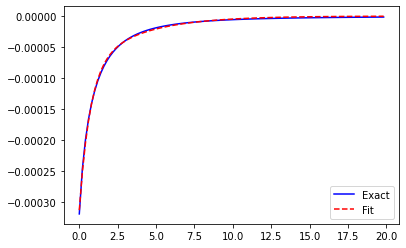

In [5]:
# Test our bi-exponential fit of the zero-temperature Matsubara contribution
plt.plot(tlist[0:100],
         [matsu(t) for t in tlist[0:100]],
         "b-", label="Exact")
plt.plot(tlist[0:100],
         [matsu_fit.value(t) for t in tlist[0:100]],
         "r--", label="Fit")
plt.legend()
plt.show()

### Influence Superoperators

Creating the influence superoperators is straightforward:

In [6]:
# Let us first define the required system operators
HQ = 0.5 * delta * sigmax() # Hamiltonian
Q = sigmaz() # Coupling operator
excited = (sigmax() + 1) / 2 # Projector on excited state

# Create Influence Phase objects
influence_phase1 = InfluencePhase.from_correlation_function(Q, cfct1)
influence_phase2 = InfluencePhase.from_correlation_function(Q, cfct2)
influence_phase3 = InfluencePhase.from_correlation_function(Q, cfct3)

### Simulation

We assume that the system is initially in the ground state.
(Note that the reservoir is always assumed to be in a thermal state initially.)

In [7]:
foo = (basis(2, 1) - basis(2, 0)) / np.sqrt(2) # Initial state vector
rho0 = foo * foo.dag() # Initial state density matrix

##### Example 1

In [8]:
solver1 = HEOM(HQ, [influence_phase1], cutoff_zeroT)
result1 = solver1.solve(rho0, tlist, e_ops=[excited], options=options)

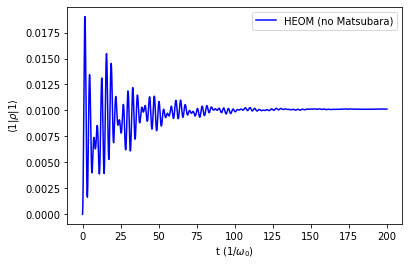

In [9]:
# Comparable to [Lambert 2019, Fig. 3a] -- there, they plot the reservoir population; here, we plot qubit population
plt.plot(tlist, result1.expect[0], color="b", label= r"HEOM (no Matsubara)")
plt.xlabel("t ($1/\omega_0$)")
plt.ylabel(r"$\langle 1 | \rho | 1 \rangle$")
plt.legend()
plt.show()

##### Example 2

In [10]:
solver2 = HEOM(HQ, [influence_phase2], cutoff_zeroT)
result2 = solver2.solve(rho0, tlist, e_ops=[excited], options=options)

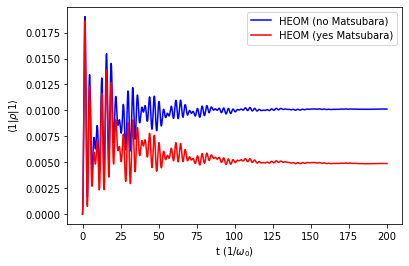

In [11]:
# Comparable to Fig. 3b
plt.plot(tlist, result1.expect[0], color="b", label=r"HEOM (no Matsubara)")
plt.plot(tlist, result2.expect[0], color="r", label=r"HEOM (yes Matsubara)")
plt.xlabel("t ($1/\omega_0$)")
plt.ylabel(r"$\langle 1 | \rho | 1 \rangle$")
plt.legend()
plt.show()

##### Example 3

In this example, we additionally demonstrate that it is straightforward to find the system and bath heat currents as defined in [Kato 2016].

In [12]:
tlist = np.linspace(0, 100, 500)

solver3 = HEOM(HQ, [influence_phase3], cutoff_finiteT)
result3 = solver3.solve(rho0, tlist, e_ops=[excited,
                                            solver3.system_heat_current(0),
                                            solver3.bath_heat_current(0)], options=options)

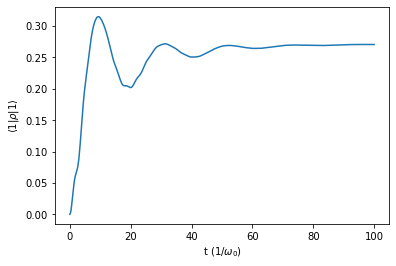

In [13]:
# Plot populations
plt.plot(tlist, result3.expect[0])
plt.xlabel("t ($1/\omega_0$)")
plt.ylabel(r"$\langle 1 | \rho | 1 \rangle$")
plt.show()

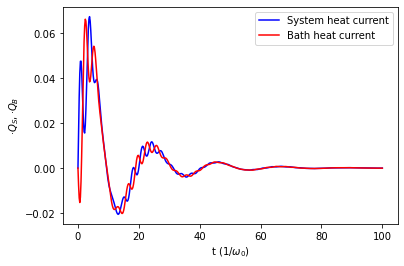

In [14]:
# Plot heat currents
plt.plot(tlist, np.real(result3.expect[1]), color="b", label=r"System heat current")
plt.plot(tlist, np.real(result3.expect[2]), color="r", label=r"Bath heat current")
plt.xlabel("t ($1/\omega_0$)")
plt.ylabel(r"$\dot Q_S, \dot Q_B$")
plt.legend()
plt.show()

### Addendum: Comparison with BoFiN

Recently, the BoFiN package was added to QuTiP, making this package mostly obsolete.
For comparison, we implement example 3 using BoFiN:

In [15]:
from qutip.nonmarkov.bofin_baths import UnderDampedBath
from qutip.nonmarkov.bofin_solvers import HEOMSolver

bofin_bath = UnderDampedBath(Q, coup_strength, 1, 2, 2 * half_width, bath_freq)
bofin_solver = HEOMSolver(HQ, bofin_bath, cutoff_finiteT, options=options)

In [16]:
# Heat currents are not part of BoFiN, need to define callback functions manually

# t: current time (unused)
# ado_state: of type HierarchyADOsState
def bath_heat_current(t, ado_state):
    l1_labels = ado_state.filter(level=1)
    result = 0
    for label in l1_labels:
        [exp] = ado_state.exps(label)
        contribution = (Q * ado_state.extract(label)).tr()
        result -= exp.vk * contribution
    return result

a_op = 1j * (Q * HQ - HQ * Q)

def system_heat_current(t, ado_state):
    l1_labels = ado_state.filter(level=1)
    result = 0
    for label in l1_labels:
        contribution = (a_op * ado_state.extract(label)).tr()
        result += contribution
    return result

In [17]:
result_bofin = bofin_solver.run(rho0, tlist, e_ops=[excited, system_heat_current, bath_heat_current])

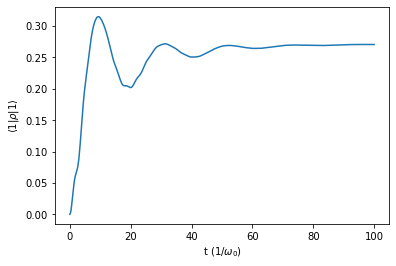

In [18]:
# Plot populations
plt.plot(tlist, result_bofin.expect[0])
plt.xlabel("t ($1/\omega_0$)")
plt.ylabel(r"$\langle 1 | \rho | 1 \rangle$")
plt.show()

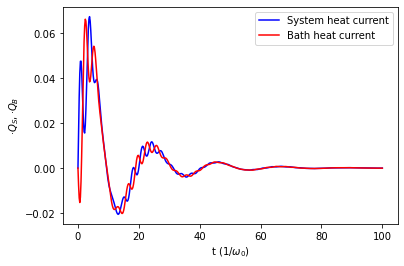

In [19]:
# Plot heat currents
plt.plot(tlist, np.real(result_bofin.expect[1]), color="b", label=r"System heat current")
plt.plot(tlist, np.real(result_bofin.expect[2]), color="r", label=r"Bath heat current")
plt.xlabel("t ($1/\omega_0$)")
plt.ylabel(r"$\dot Q_S, \dot Q_B$")
plt.legend()
plt.show()